# Decision Tree: Model Selection & Hadling Overfitting

The goal of this notebook is two-fold.
- Model selection for a Decision Tree Classifier via hyperparameter tuning
- Understand how hyperparameter tuning reduces variance (handles overfitting)


In [148]:
import numpy as np

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

# Dataset

We will use Scikit-Learn's "datasets.make_moons" function to generate a synthetic non-linear dataset that is suitable for investigating classification (as well as clustering) models. It creates two interleaving half circles.

The following parameter is used by the make_moons function:

- noise : Standard deviation of Gaussian noise added to the data.

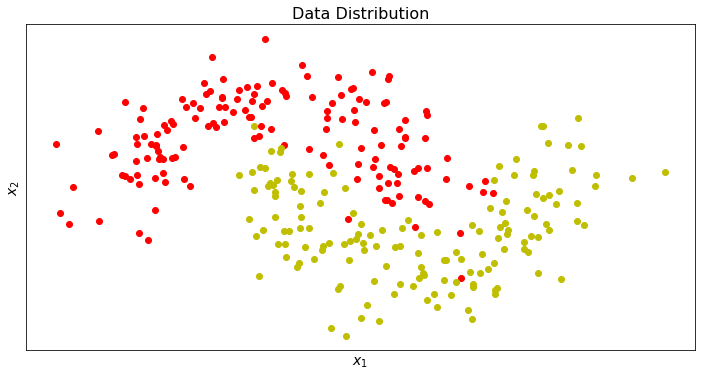

In [222]:
X, y = make_moons(300, noise=0.25, random_state=0)

plt.figure(figsize=(12, 6))
plt.plot(X[y.ravel()==0, 0], X[y.ravel()==0, 1], "ro")
plt.plot(X[y.ravel()==1, 0], X[y.ravel()==1, 1], "yo")
plt.title("Data Distribution", fontsize=16)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)
plt.xticks(())
plt.yticks(())
plt.show()

## Split the Dataset into Train and Test Set

In [223]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Function for Plotting Decision Bounday 


To better understand how Decision Tree classifier creates decision boundary, we need to **<font color=red size=6> visualize </font>** it.

We define the function "decision_boundary_decision_tree" to plot the decision boundary. 

In [224]:
def decision_boundary_decision_tree(clf, X, colorBar=False):
    
    # Get the min and max value of feature x1
    x1min, x1max = X[:,0].min() - 0.5, X[:, 0].max() + 0.5
    
    # Get the min and max value of feature x2
    x2min, x2max = X[:,1].min() - 0.5, X[:, 1].max() + 0.5
    
    # Create the mesh grid
    x1s = np.linspace(x1min, x1max, 100)
    x2s = np.linspace(x2min, x2max, 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    
    
    # Create pairs of new points from the grid
    X_new = np.c_[x1.ravel(), x2.ravel()]
    
    
    # Compute the class predictions for all new points
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    
    # Generate the contourf plot for the predictions
    plt.contourf(x1, x2, y_pred, cmap=plt.cm.bwr, alpha=0.2)
    
    
    if(colorBar==True):
        plt.colorbar()   

## Model Selection: Hyperparameter Tuning

We perform model selection by finding the optimal hyperparameters via Gridsearch.

We tune the following two hyperparameters that influence variance (overfitting).

- min_samples_leaf
- max_depth

In [225]:
%%time

param_grid = {'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8],
              'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10]}

dt_clf = DecisionTreeClassifier()

dt_clf_cv = GridSearchCV(dt_clf, param_grid, scoring='f1', cv=4)
dt_clf_cv.fit(X_train, y_train)

params_optimal = dt_clf_cv.best_params_

print("Best Score (accuracy): %f" % dt_clf_cv.best_score_)
print("Optimal Hyperparameter Values: ", params_optimal)

Best Score (accuracy): 0.954409
Optimal Hyperparameter Values:  {'min_samples_leaf': 3, 'max_depth': 7}
CPU times: user 615 ms, sys: 3.62 ms, total: 618 ms
Wall time: 617 ms


/Users/hasan/anaconda/lib/python3.5/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


## Train the Optimal Classifier

In [226]:
tree_clf = DecisionTreeClassifier(**params_optimal)

tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

## Evaluate the Optimal Classifier on Test Data

In [227]:
y_test_predicted = tree_clf.predict(X_test)

test_accuracy_tuned = accuracy_score(y_test, y_test_predicted)
print("Test Accuracy: ", test_accuracy_tuned)

print("\nTest Confusion Matrix:")
print(confusion_matrix(y_test, y_test_predicted))

print("\nClassification Report:")
print(classification_report(y_test, y_test_predicted))

Test Accuracy:  0.9333333333333333

Test Confusion Matrix:
[[34  3]
 [ 1 22]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.94        37
           1       0.88      0.96      0.92        23

   micro avg       0.93      0.93      0.93        60
   macro avg       0.93      0.94      0.93        60
weighted avg       0.94      0.93      0.93        60



## Training a Classsifer Without Hyperparameter Tuning

We train a classsifier without using optimal hyperparameters.

We expect it to have larger variance.

Then, we compare its decision boundary (and accuracy) with that of the optimal classsifier.

In [220]:
tree_clf_untuned = DecisionTreeClassifier(random_state=42)
tree_clf_untuned.fit(X_train, y_train)

y_test_predicted_untuned = tree_clf_untuned.predict(X_test)

test_accuracy_untuned = accuracy_score(y_test, y_test_predicted_untuned)
print("Test Accuracy: ", test_accuracy_untuned)

Test Accuracy:  0.9166666666666666


## Comparing The Decision Boundaries of Two Classsifiers

We see that the non-optimal model has larger variance (low test accuracy) resulting into overfitted decision boundary.

However, the optimal model decision decision boundary is smoother and it has higher test accuracy.

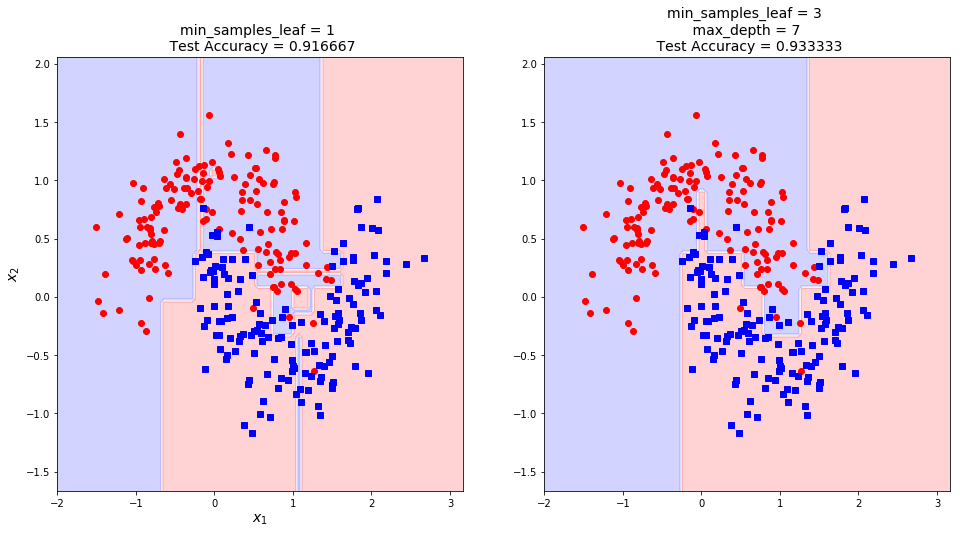

In [221]:
plt.figure(figsize=(16, 8))

plt.subplot(121)
decision_boundary_decision_tree(tree_clf_1, X)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.title("min_samples_leaf = %d \n Test Accuracy = %f" 
          % (tree_clf_untuned.min_samples_leaf, test_accuracy_untuned), fontsize=14)
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$x_2$", fontsize=14)

plt.subplot(122)
decision_boundary_decision_tree(tree_clf_2, X)

plt.plot(X[:, 0][y==0], X[:, 1][y==0], "ro")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.title("min_samples_leaf = %d \n max_depth = %d \n Test Accuracy = %f" 
          % (tree_clf.min_samples_leaf, tree_clf.max_depth, test_accuracy_tuned), fontsize=14)

plt.show()